# Name: Jaskirat Singh; Roll No:102017175; Subgroup: CS8

## Assignment 4

In [1]:
import pandas as pd
import numpy as np

### Q1

In [2]:
data = [['sunny',85,85,'false','no'],
       ['sunny',80,90,'true','no'],
       ['overcast',83,78,'false','yes'],
       ['rain',70,96,'false','yes'],
       ['rain',68,80,'false','yes'],
       ['rain',65,70,'true','no'],
       ['overcast',64,65,'true','yes'],
       ['sunny',72,95,'false','no'],
       ['sunny',69,70,'false','yes'],
       ['rain',75,80,'false','yes'],
       ['sunny',75,70,'true','yes'],
       ['overcast',72,90,'true','yes'],
       ['overcast',81,75,'false','yes'],
       ['rain',71,80,'true','no']]

In [3]:
df = pd.DataFrame(data=data,columns=['Outlook','Temperature','Humidity','Windy','Play'])
df

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,85,85,false,no
1,sunny,80,90,true,no
2,overcast,83,78,false,yes
3,rain,70,96,false,yes
4,rain,68,80,false,yes
5,rain,65,70,true,no
6,overcast,64,65,true,yes
7,sunny,72,95,false,no
8,sunny,69,70,false,yes
9,rain,75,80,false,yes


(a) Encode the Temperature and Humidity as binary column wit values True/False using a
threshold being decided by Gain Ratio.

In [4]:
def find_entropy(df):
    target = df.keys()[-1]
    target_values = df[target].unique()
    entropy=0
    for value in target_values:
        prob = len(df[df[target]==value])/len(df)
        entropy += -(prob*np.log2(prob))
    return entropy

In [5]:
find_entropy(df)

0.9402859586706311

In [6]:
#countinuous value to binary
def cont_to_bin(df, attribute):
    df2 = df.sort_values(by=[attribute])
    GainRatio = []
    Class = df2.keys()[-1]
    unique_vals = df2[Class].unique()
    for temp in df2[attribute][:-1]:
        entropySub = 0
        avgInfoEntropy = 0
        SplitInfo = 0
        for val in unique_vals:
            num = len(df2[attribute][df2[attribute] <= temp][df2[Class] == val])
            den = len(df2[attribute][df2[attribute] <= temp])
            prob = num/den
            entropySub += -(prob*np.log2(prob+1e-10))
        weight = den/len(df2)
        avgInfoEntropy += weight*entropySub
        SplitInfo += -(weight*np.log2(weight))
        entropySub = 0
        for val in unique_vals:
            num = len(df2[attribute][df2[attribute] > temp][df2[Class] == val])
            den = len(df2[attribute][df2[attribute] > temp])
            prob = num/den
            entropySub += -(prob*np.log2(prob+1e-10))
        weight = den/len(df2)
        avgInfoEntropy += weight*entropySub
        SplitInfo += -(weight*np.log2(weight))
        IG = find_entropy(df2)-avgInfoEntropy
        GR = IG/SplitInfo
        GainRatio.append(GR)
    max_gain = max(GainRatio)
    max_index =np.argmax(GainRatio)+1
    df2.iloc[max_index:,df2.columns.get_loc(attribute)] = 'High'
    df2.iloc[:max_index,df2.columns.get_loc(attribute)] = 'Low'
    return df2

In [7]:
df = cont_to_bin(df,'Temperature')
df = cont_to_bin(df,'Humidity')
df

,Outlook,Temperature,Humidity,Windy,Play
6,overcast,Low,Low,true,yes
5,rain,Low,High,true,no
8,sunny,Low,High,false,yes
10,sunny,Low,High,true,yes
12,overcast,Low,High,false,yes
2,overcast,Low,High,false,yes
4,rain,Low,High,false,yes
13,rain,Low,High,true,no
9,rain,Low,High,false,yes
0,sunny,High,High,false,no


(b) Train a C4.5 Decision Tree Classifier on the transformed dataset.

In [8]:
def find_average_info_entropy(df, attribute):
    target = df.keys()[-1]
    target_values = df[target].unique()
    attr_values = df[attribute].unique()
    average_info_entropy = 0
    for value1 in attr_values:
        entropy_subsample = 0
        for value2 in target_values:
            num = len(df[attribute][df[attribute]==value1][df[target]==value2])
            den = len(df[attribute][df[attribute]==value1])
            prob = num/den
            entropy_subsample += -(prob*np.log2(prob+1e-7)) 
        weight = den/len(df)
        average_info_entropy += weight*entropy_subsample        
    return average_info_entropy

In [9]:
def find_split_info(df, attribute):
    target = df.keys()[-1]
    target_values = df[target].unique()
    attr_values = df[attribute].unique()
    split_info = 0
    for value1 in attr_values:
        entropy_subsample = 0
        Sv = len(df[attribute][df[attribute]==value1])
        weight = Sv/len(df)
        split_info += -weight*np.log2(weight+1e-7)
    return split_info

In [10]:
find_average_info_entropy(df,'Outlook')

0.6935358915770655

In [11]:
find_average_info_entropy(df,'Temperature')

0.826884816255516

In [12]:
find_split_info(df, 'Outlook')

1.5774058500438985

In [13]:
find_split_info(df, 'Temperature')

0.3712320381019763

In [14]:
def find_winner(df):
    attributes = df.keys()[:-1]
    IG = []
    GR = []
    for attribute in attributes:
        #print(attribute)
        IG.append(find_entropy(df) - find_average_info_entropy(df, attribute))
        GR.append((find_entropy(df) - find_average_info_entropy(df, attribute))/find_split_info(df, attribute))
    # print(IG)
    # print(GR)
    return df.keys()[:-1][np.argmax(GR)]

In [15]:
find_winner(df)

'Temperature'

(c) Using Gain Ratio, find the best two attributes that decide the Play attribute.

In [16]:
def find_best_feature(df,tree=None,cnt=1):
    Class=df.keys()[-1]
    attribute=find_winner(df)
    print("Best Feature ", cnt," : ", attribute)
    if(cnt == 2):
        return 0
    if tree is None:
        tree={}
        tree[attribute]={}
    unique_value=df[attribute].unique()
    for value in unique_value:
        subsample=df[df[attribute]==value].reset_index(drop=True)
        ClValue,counts=np.unique(subsample[Class],return_counts=True)
        if len(counts)==1:
            tree[attribute][value]=ClValue[0]
        elif(cnt < len(df.keys())-1):
            tree[attribute][value]=find_best_feature(subsample,cnt=cnt+1)
        else: 
            if(counts[1]/sum(counts) <= 0.5) : 
                tree[attribute][value] = ClValue[0]
            else:
                tree[attribute][value] = ClValue[1]
    #return tree

In [17]:
find_best_feature(df)

Best Feature  1  :  Temperature
Best Feature  2  :  Outlook


(d) Using χ^2 test, check whether Play label depends upon Outlook feature or not at 95% confidence 
level.

In [18]:
from scipy.stats import chi2_contingency

contigency= pd.crosstab(df['Outlook'], df['Play'])
stat, p, dof, expected = chi2_contingency(contigency)
alpha = 0.05
print("p value: " + str(p))
if p <= alpha:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

p value: 0.16976615743981122
Accept Null Hypothesis


### Q2. Refer to Q4 of Assignment II, find word embeddings of the PPMI matrix of dimensionality 500 using SVD decomposition (using step-by-step implementation)

In [19]:
df=pd.read_csv('IMDB_Dataset.csv',nrows=500)

In [20]:
corpus=[]
for i in range(len(df)):
    corpus.append(df['review'][i])
corpus[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [21]:
corpus_final=[]
for i in range(len(corpus)):
    corpus_final.append(" ".join([word.lower() for word in corpus[i].split() if word.isalpha()]))

In [22]:
document_frequency={}
for i in range(len(corpus_final)):
    word_frequency={}
    for word in corpus_final[i].split():
        word_frequency[word]=1
    document_frequency[i]=word_frequency
document_frequency[0]

{'one': 1,
 'of': 1,
 'the': 1,
 'other': 1,
 'reviewers': 1,
 'has': 1,
 'mentioned': 1,
 'that': 1,
 'after': 1,
 'watching': 1,
 'just': 1,
 'oz': 1,
 'episode': 1,
 'be': 1,
 'they': 1,
 'are': 1,
 'as': 1,
 'this': 1,
 'is': 1,
 'exactly': 1,
 'what': 1,
 'happened': 1,
 'with': 1,
 'first': 1,
 'thing': 1,
 'struck': 1,
 'me': 1,
 'about': 1,
 'was': 1,
 'its': 1,
 'brutality': 1,
 'and': 1,
 'unflinching': 1,
 'scenes': 1,
 'which': 1,
 'set': 1,
 'in': 1,
 'right': 1,
 'from': 1,
 'word': 1,
 'trust': 1,
 'not': 1,
 'a': 1,
 'show': 1,
 'for': 1,
 'faint': 1,
 'hearted': 1,
 'or': 1,
 'pulls': 1,
 'no': 1,
 'punches': 1,
 'regards': 1,
 'to': 1,
 'sex': 1,
 'classic': 1,
 'use': 1,
 'called': 1,
 'nickname': 1,
 'given': 1,
 'oswald': 1,
 'maximum': 1,
 'security': 1,
 'state': 1,
 'it': 1,
 'focuses': 1,
 'mainly': 1,
 'on': 1,
 'emerald': 1,
 'an': 1,
 'experimental': 1,
 'section': 1,
 'prison': 1,
 'where': 1,
 'all': 1,
 'cells': 1,
 'have': 1,
 'glass': 1,
 'fronts': 1,
 

In [23]:
bow=pd.DataFrame(document_frequency)
bow.fillna(0,inplace=True)
bow.shape

(10354, 500)

In [24]:
cooccur_mat=bow.values.dot(bow.values.T)
np.fill_diagonal(cooccur_mat,0)
cooccur_mat

array([[  0., 247., 250., ...,   1.,   1.,   1.],
       [247.,   0., 477., ...,   1.,   1.,   1.],
       [250., 477.,   0., ...,   1.,   1.,   1.],
       ...,
       [  1.,   1.,   1., ...,   0.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   0.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   0.]])

In [66]:
U, s, VT = np.linalg.svd(cooccur_mat)
U

array([[-1.00713013e-01, -1.28296447e-02,  2.18101248e-04, ...,
         5.50281772e-03,  5.39406375e-04, -4.09627277e-03],
       [-1.75892547e-01, -1.09708400e-01,  1.45462666e-01, ...,
         2.44667408e-03,  1.59738966e-03,  2.11508627e-03],
       [-1.80185572e-01, -1.20794391e-01, -9.06843505e-01, ...,
         2.22518667e-03, -2.82326862e-03,  1.00185080e-03],
       ...,
       [-6.65027944e-04,  5.68644972e-03,  3.84952401e-06, ...,
         6.19531131e-04, -5.62430090e-04, -8.54453414e-04],
       [-6.65027944e-04,  5.68644972e-03,  3.84952401e-06, ...,
         6.19531131e-04, -5.62430090e-04, -8.54453414e-04],
       [-6.65027944e-04,  5.68644972e-03,  3.84952401e-06, ...,
         6.19531131e-04, -5.62430090e-04, -8.54453414e-04]])

### Q3: Implement Linear Discriminant Analysis (LDA) step-by-step on Iris dataset (present in sklearn.datasets).

In [25]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder

In [26]:
iris = load_iris()
df = pd.DataFrame(data = np.c_[iris['data']])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.columns = ['s_length', 's_width', 'p_length', 'p_width', 'species']
df.head()

,s_length,s_width,p_length,p_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [27]:
X = df.iloc[:,:4].values
y = df['species'].values
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

In [28]:
mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.428 1.462 0.246]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



In [29]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) 
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]


In [30]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) 
    overall_mean = overall_mean.reshape(4,1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


In [31]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.20874182]
 [ 0.38620369]
 [-0.55401172]
 [-0.7073504 ]]
Eigenvalue 1: 3.22e+01

Eigenvector 2: 
[[-0.00653196]
 [-0.58661055]
 [ 0.25256154]
 [-0.76945309]]
Eigenvalue 2: 2.85e-01

Eigenvector 3: 
[[ 0.88513899]
 [-0.29455053]
 [-0.27255052]
 [-0.23555291]]
Eigenvalue 3: 3.53e-15

Eigenvector 4: 
[[-0.80593687]
 [ 0.40432808]
 [ 0.41273963]
 [-0.12895956]]
Eigenvalue 4: 3.17e-17


In [32]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

In [33]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.19192919827803
0.28539104262306414
3.5296362660244315e-15
3.17116800810927e-17


In [34]:
print('Explained Variance :\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Explained Variance :

eigenvalue 1: 99.12%
eigenvalue 2: 0.88%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [35]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.20874182 -0.00653196]
 [ 0.38620369 -0.58661055]
 [-0.55401172  0.25256154]
 [-0.7073504  -0.76945309]]


In [36]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

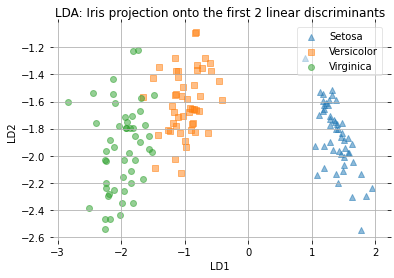

In [37]:
from matplotlib import pyplot as plt

ax = plt.subplot(111)
for label,marker,color in zip(
    range(1,4),('^', 's', 'o'),('b en')):

    plt.scatter(x=X_lda[:,0].real[y == label],
            y=X_lda[:,1].real[y == label],
            marker=marker,
            cmap='viridis',
            alpha=0.5,
            label=label_dict[label]
            )

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.title('LDA: Iris projection onto the first 2 linear discriminants')

plt.tick_params(axis="both", which="both", bottom="off", top="off",  
        labelbottom="on", left="off", right="off", labelleft="on")

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)    

plt.grid()
plt.tight_layout
plt.show()

### Q4: Download the dataset regarding Car Price Prediction from the following link:
https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

1. Load the dataset with following column names ["symboling", "normalized_losses",
"make", "fuel_type", "aspiration","num_doors", "body_style", "drive_wheels",
"engine_location", "wheel_base", "length", "width", "height", "curb_weight", 
"engine_type", "num_cylinders", "engine_size", "fuel_system", "bore", "stroke",
"compression_ratio", "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]
and replace all ? values with NaN

In [38]:
df4 = pd.read_csv('imports-85.data', header=None)

In [39]:
df4.columns = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration","num_doors", "body_style", "drive_wheels",
"engine_location", "wheel_base", "length", "width", "height", "curb_weight", "engine_type", "num_cylinders", "engine_size",
"fuel_system", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]

In [40]:
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [41]:
df4 = df4.replace('?', np.nan)
df4.head(10)

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160,5500,16,22,NaN


In [42]:
df4.shape

(205, 26)

In [43]:
df4.isna().sum()

symboling             0
normalized_losses    41
make                  0
fuel_type             0
aspiration            0
num_doors             2
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_cylinders         0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

2. Replace all NaN values with central tendency imputation. Drop the rows with NaN values
in price column

In [44]:
df4['price'].isna().sum()

4

In [45]:
df4 = df4[~df4['price'].isna()]

In [46]:
df4['price'].isna().sum()

0

In [47]:
df4.isna().sum()

symboling             0
normalized_losses    37
make                  0
fuel_type             0
aspiration            0
num_doors             2
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_cylinders         0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 0
dtype: int64

In [48]:
df4['normalized_losses'].fillna(df4['normalized_losses'].median(), inplace=True)
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,115.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [49]:
cols = ['num_doors', 'bore', 'stroke', 'horsepower', 'peak_rpm']
for col in cols:
    df4[col].fillna(df4[col].mode()[0], inplace=True)
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,115.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [50]:
df4.isna().sum()

symboling            0
normalized_losses    0
make                 0
fuel_type            0
aspiration           0
num_doors            0
body_style           0
drive_wheels         0
engine_location      0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_type          0
num_cylinders        0
engine_size          0
fuel_system          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

3. Using isolation forest technique (present in sklearn.ensemble) identify outliers present in
length column.

In [51]:
from sklearn.ensemble import IsolationForest

In [52]:
iso = IsolationForest(random_state=19)
predict = iso.fit_predict(df4[['length']])
predict

array([ 1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,
       -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,
        1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [53]:
outlierIndices=np.where(predict==-1)
outlierIndices

(array([  6,   7,   8,  15,  16,  17,  18,  19,  29,  30,  31,  32,  33,
         34,  35,  44,  45,  46,  47,  48,  49,  64,  65,  67,  68,  69,
         70,  71,  95,  98,  99, 100, 103, 106, 107, 110, 111, 126, 134,
        135, 146, 147, 148, 174, 175, 185, 189], dtype=int64),)

In [54]:
df4['length'].iloc[outlierIndices].values

array([192.7, 192.7, 192.7, 193.8, 197. , 141.1, 155.9, 158.8, 144.6,
       144.6, 150. , 150. , 150. , 163.4, 157.1, 199.6, 199.6, 191.7,
       159.1, 159.1, 159.1, 190.9, 190.9, 202.6, 202.6, 180.3, 208.1,
       199.2, 162.4, 181.7, 184.6, 184.6, 178.5, 198.9, 198.9, 198.9,
       198.9, 181.5, 156.9, 157.9, 158.7, 158.7, 158.7, 183.5, 183.5,
       159.3, 183.1])

4. There are 10 columns in the dataset with non-numeric values. Convert these values to
numeric values using following scheme:
- For “num_doors” and “num_cylinders”: convert words (number names) to figures
for e.g., two to 2
- For "body_style", "drive_wheels": use dummy encoding scheme
- For “make”, “aspiration”, “engine_location”,fuel_type: use label encoding scheme
- For fuel_system: replace values containing string pfi to 1 else all values to 0.
- For engine_type: replace values containing string ohc to 1 else all values to 0.

In [55]:
df4['num_doors'].unique()

array(['two', 'four'], dtype=object)

In [56]:
df4['num_cylinders'].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

In [57]:
num_dict = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'zero' : 0,
    'ten' : 10,
    'eleven' : 11,
    'twelve':12
}

In [58]:
df4['num_doors']=df4['num_doors'].apply(lambda x: num_dict[x])
df4['num_cylinders']=df4['num_cylinders'].apply(lambda x: num_dict[x])
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,115.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,115.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,115.0,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,4,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,4,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [59]:
dummies = pd.get_dummies(df4[["body_style", "drive_wheels"]])
df4 = pd.concat((df4,dummies),axis=1)
df4.drop(columns=["body_style", "drive_wheels"],inplace=True)
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,3,115.0,alfa-romero,gas,std,2,front,88.6,168.8,64.1,...,27,13495,1,0,0,0,0,0,0,1
1,3,115.0,alfa-romero,gas,std,2,front,88.6,168.8,64.1,...,27,16500,1,0,0,0,0,0,0,1
2,1,115.0,alfa-romero,gas,std,2,front,94.5,171.2,65.5,...,26,16500,0,0,1,0,0,0,0,1
3,2,164,audi,gas,std,4,front,99.8,176.6,66.2,...,30,13950,0,0,0,1,0,0,1,0
4,2,164,audi,gas,std,4,front,99.4,176.6,66.4,...,22,17450,0,0,0,1,0,1,0,0


In [60]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
encodingFeatures=['make', 'aspiration', 'engine_location','fuel_type']
for attributes in encodingFeatures:
    df4[attributes]=pd.Series(le.fit_transform(df4[attributes]))
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,3,115.0,0.0,1.0,0.0,2,0.0,88.6,168.8,64.1,...,27,13495,1,0,0,0,0,0,0,1
1,3,115.0,0.0,1.0,0.0,2,0.0,88.6,168.8,64.1,...,27,16500,1,0,0,0,0,0,0,1
2,1,115.0,0.0,1.0,0.0,2,0.0,94.5,171.2,65.5,...,26,16500,0,0,1,0,0,0,0,1
3,2,164,1.0,1.0,0.0,4,0.0,99.8,176.6,66.2,...,30,13950,0,0,0,1,0,0,1,0
4,2,164,1.0,1.0,0.0,4,0.0,99.4,176.6,66.4,...,22,17450,0,0,0,1,0,1,0,0


In [61]:
def keyEncode(string,substr):
    if string.count(substr):
        return(1)
    else:
        return(0)

In [62]:
df4[['fuel_system']]=df4[['fuel_system']].applymap(lambda x: keyEncode(x,'pfi'))
df4[['engine_type']]=df4[['engine_type']].applymap(lambda x: keyEncode(x,'ohc'))
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,3,115.0,0.0,1.0,0.0,2,0.0,88.6,168.8,64.1,...,27,13495,1,0,0,0,0,0,0,1
1,3,115.0,0.0,1.0,0.0,2,0.0,88.6,168.8,64.1,...,27,16500,1,0,0,0,0,0,0,1
2,1,115.0,0.0,1.0,0.0,2,0.0,94.5,171.2,65.5,...,26,16500,0,0,1,0,0,0,0,1
3,2,164,1.0,1.0,0.0,4,0.0,99.8,176.6,66.2,...,30,13950,0,0,0,1,0,0,1,0
4,2,164,1.0,1.0,0.0,4,0.0,99.4,176.6,66.4,...,22,17450,0,0,0,1,0,1,0,0


5. Divide the dataset into input features (all columns except price) and output variable (price).
Scale all input features.

In [63]:
numeric_columns = df4.columns

In [64]:
numeric_columns = numeric_columns.drop('price')
print(numeric_columns)
Y = df4[['price']]

Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_doors', 'engine_location', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_type', 'num_cylinders', 'engine_size',
       'fuel_system', 'bore', 'stroke', 'compression_ratio', 'horsepower',
       'peak_rpm', 'city_mpg', 'highway_mpg', 'body_style_convertible',
       'body_style_hardtop', 'body_style_hatchback', 'body_style_sedan',
       'body_style_wagon', 'drive_wheels_4wd', 'drive_wheels_fwd',
       'drive_wheels_rwd'],
      dtype='object')


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df4[numeric_columns]=pd.DataFrame(scaler.fit_transform(df4[numeric_columns]),columns=numeric_columns)
df4.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,1.725050,-0.178306,-1.988794,0.336146,-0.472866,-1.156378,-0.124354,-1.685107,-0.439409,-0.853460,...,-0.542288,13495,5.700877,-0.203595,-0.715037,-0.937286,-0.376889,-0.203595,-1.192345,1.296148
1,1.725050,-0.178306,-1.988794,0.336146,-0.472866,-1.156378,-0.124354,-1.685107,-0.439409,-0.853460,...,-0.542288,16500,5.700877,-0.203595,-0.715037,-0.937286,-0.376889,-0.203595,-1.192345,1.296148
2,0.127193,-0.178306,-1.988794,0.336146,-0.472866,-1.156378,-0.124354,-0.710103,-0.244152,-0.185597,...,-0.689386,16500,-0.175412,-0.203595,1.398529,-0.937286,-0.376889,-0.203595,-1.192345,1.296148
3,0.926121,1.351431,-1.828158,0.336146,-0.472866,0.864769,-0.124354,0.165748,0.195176,0.148335,...,-0.100993,13950,-0.175412,-0.203595,-0.715037,1.066910,-0.376889,-0.203595,0.838683,-0.771517
4,0.926121,1.351431,-1.828158,0.336146,-0.472866,0.864769,-0.124354,0.099646,0.195176,0.243744,...,-1.277779,17450,-0.175412,-0.203595,-0.715037,1.066910,-0.376889,4.911721,-1.192345,-0.771517
